# Predicción de Series Temporales con Redes Neuronales

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.callbacks import EarlyStopping



In [18]:
PASOS=30

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [19]:

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten, Input
from sklearn.preprocessing import MinMaxScaler

### Cargamos nuestro Dataset

In [20]:
# Leer el archivo CSV en un DataFrame
data = pd.read_csv('AAPL.csv', parse_dates=[0], dayfirst=True,header=None, index_col=0, names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])

# Convertir el DataFrame a una Serie
df = data["Close"].squeeze()

# Mostrar las primeras filas de la Serie
print(df.head())

Date
2010-01-04    6.424605
2010-01-05    6.435713
2010-01-06    6.333344
2010-01-07    6.321636
2010-01-08    6.363664
Name: Close, dtype: float64


In [21]:
print(df.index.min())
print(df.index.max())

2010-01-04 00:00:00
2022-12-30 00:00:00


In [22]:
print(len(df['2018']))

251


In [23]:
meses =df.resample('M').mean()
meses

Date
2010-01-31      6.235636
2010-02-28      5.967873
2010-03-31      6.706821
2010-04-30      7.539509
2010-05-31      7.548904
                 ...    
2022-08-31    164.253001
2022-09-30    150.625173
2022-10-31    142.759810
2022-11-30    143.781287
2022-12-31    135.959211
Freq: M, Name: Close, Length: 156, dtype: float64

## Visualizaciones

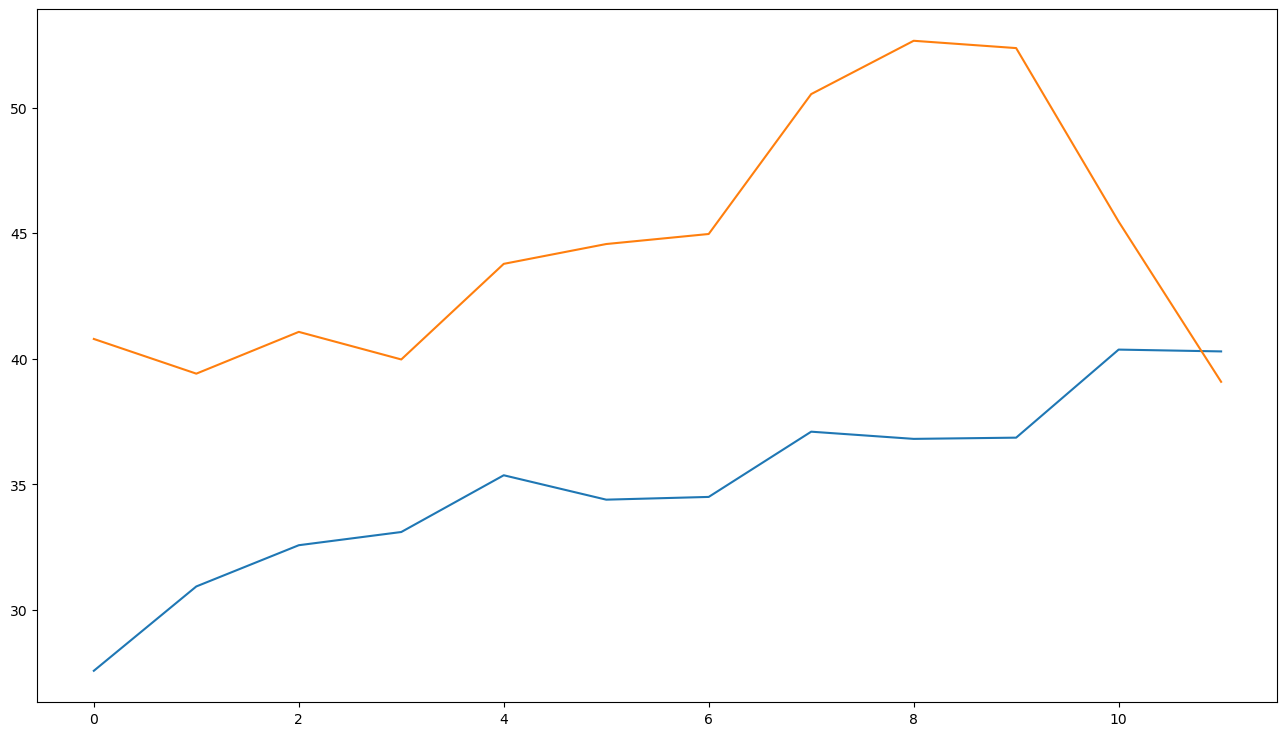

In [24]:
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)


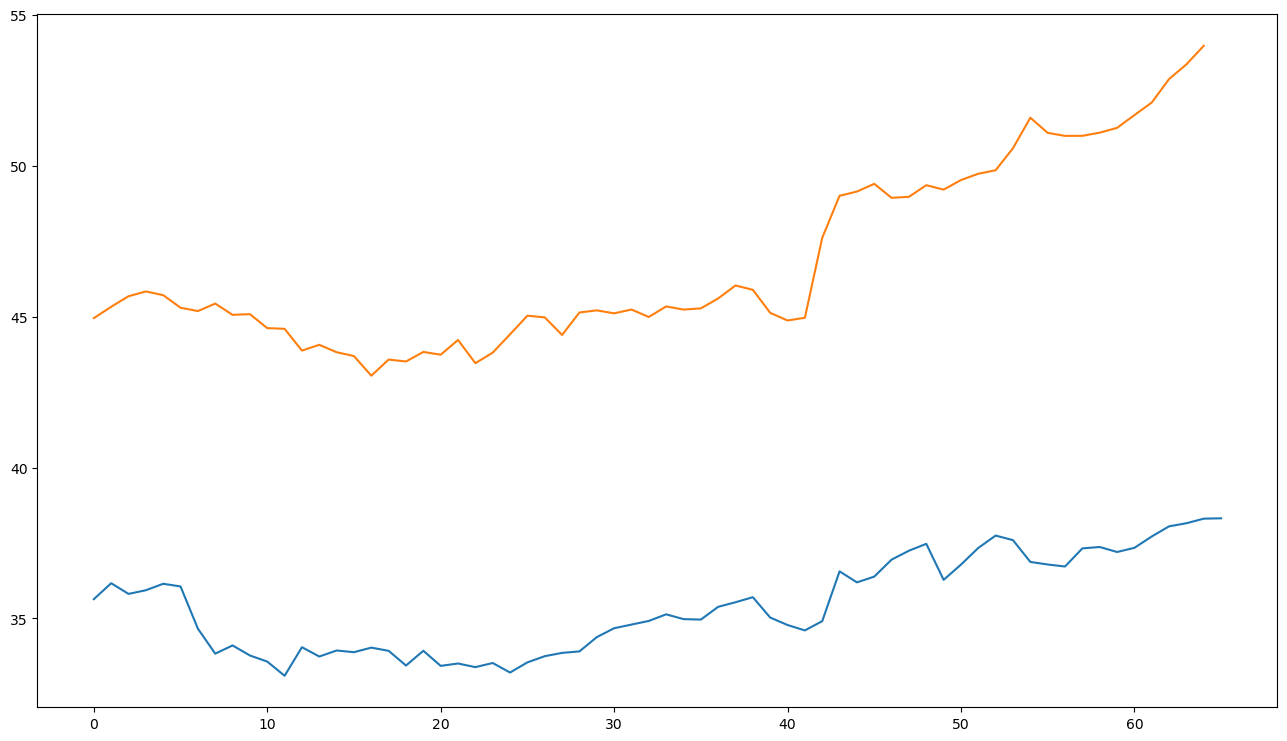

In [25]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

# Preprocesado de los datos

In [26]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
scaler_raw = MinMaxScaler(feature_range=(-1, 1))
values = df.values.astype('float32').reshape(-1,1)   # 1D -> (n,1)
scaled = scaler_raw.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
30,-0.992365,-0.992236,-0.993422,-0.993557,-0.993070,-0.993721,-0.994552,-0.993533,-0.993957,-0.995174,...,-0.997504,-1.000000,-0.998814,-0.999280,-0.998561,-0.998933,-0.997698,-0.997104,-0.996054,-0.996349
31,-0.992236,-0.993422,-0.993557,-0.993070,-0.993721,-0.994552,-0.993533,-0.993957,-0.995174,-0.992006,...,-1.000000,-0.998814,-0.999280,-0.998561,-0.998933,-0.997698,-0.997104,-0.996054,-0.996349,-0.996217
32,-0.993422,-0.993557,-0.993070,-0.993721,-0.994552,-0.993533,-0.993957,-0.995174,-0.992006,-0.993157,...,-0.998814,-0.999280,-0.998561,-0.998933,-0.997698,-0.997104,-0.996054,-0.996349,-0.996217,-0.996655
33,-0.993557,-0.993070,-0.993721,-0.994552,-0.993533,-0.993957,-0.995174,-0.992006,-0.993157,-0.994430,...,-0.999280,-0.998561,-0.998933,-0.997698,-0.997104,-0.996054,-0.996349,-0.996217,-0.996655,-0.997090
34,-0.993070,-0.993721,-0.994552,-0.993533,-0.993957,-0.995174,-0.992006,-0.993157,-0.994430,-0.998018,...,-0.998561,-0.998933,-0.997698,-0.997104,-0.996054,-0.996349,-0.996217,-0.996655,-0.997090,-0.998258


## Dividimos en set de Entrenamiento y Validación

In [27]:
# split into train and test sets
values = reframed.values
n_train_days = int(len(values) * 0.8)

train = values[:n_train_days, :]
test = values[n_train_days:, :]
'''
# Escalar los datos por separado
scaler = MinMaxScaler(feature_range=(-1, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)'''

# separar X / y (ya están en escala porque 'scaled' fue previo)
x_train, y_train = train[:, :-1], train[:, -1]
x_val,   y_val   = test[:, :-1],  test[:, -1]

# reshape para modelo (timesteps=1, features = número de lags)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val   = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print("shapes:", x_train.shape, y_train.shape, x_val.shape, y_val.shape)


shapes: (2593, 1, 30) (2593,) (649, 1, 30) (649,)


# Tercer (v1) modificación del modelo

## Utilizaremos una Red "normal" Feedforward

In [28]:

'''
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='SGD',metrics=['mse', 'mae', 'mape'])
    model.summary()
    return model
'''
'''def crear_modeloFF():
    model = Sequential()
    model.add(Input(shape=(PASOS, 1)))  # cada paso tiene una sola característica
    model.add(Flatten()) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))  # salida sin restricción

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error',optimizer=optimizer,metrics=['mse', 'mae', 'mape','r2_score'])
    model.summary()
    return model'''



def crear_modeloFF(n_timesteps,n_features):
    model = Sequential()
    model.add(Input(shape=(n_timesteps, n_features)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))  # Regularización
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mse', 'mae', 'mape'])
    model.summary()
    return model

## Entrenamos nuestra máquina

In [29]:
EPOCHS=15

PASOS= x_train.shape[1]
print("PASOS:", PASOS)
N_FEATURES= x_train.shape[2]
print("N_FEATURES:", N_FEATURES)
model = crear_modeloFF(PASOS,N_FEATURES)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS, callbacks=[early_stopping])
#history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

PASOS: 1
N_FEATURES: 30


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 3s 845us/step - loss: 0.0970 - mae: 0.0970 - mape: 14.2731 - mse: 0.0203 - val_loss: 0.1277 - val_mae: 0.1277 - val_mape: 75.1161 - val_mse: 0.0239
Epoch 2/15
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 2s 790us/step - loss: 0.0388 - mae: 0.0388 - mape: 5.8683 - mse: 0.0030 - val_loss: 0.2189 - val_mae: 0.2189 - val_mape: 104.0137 - val_mse: 0.0583
Epoch 3/15
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step - loss: 0.0299 - mae: 0.0299 - mape: 4.5028 - mse: 0.0023 - val_loss: 0.5407 - val_mae: 0.5407 - val_mape: 149.3848 - val_mse: 0.3304
Epoch 4/15
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 2s 797us/step - loss: 0.0275 - mae: 0.0275 - mape: 4.3391 - mse: 0.0019 - val_loss: 0.6902 - val_mae: 0.6902 - val_mape: 211.0532 - val_mse: 0.5332
Epoch 5/15
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 2s 818us/step - loss: 0.0250 - mae: 0.0250 - mape: 3.7933 - mse: 0.0015 - val_loss: 0.7464 - val_mae: 0.7464 - val_mape: 214.2387 - val_mse: 0.6320
Epoch 6/15
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 2s 794us

## Visualizamos Resultados

In [30]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


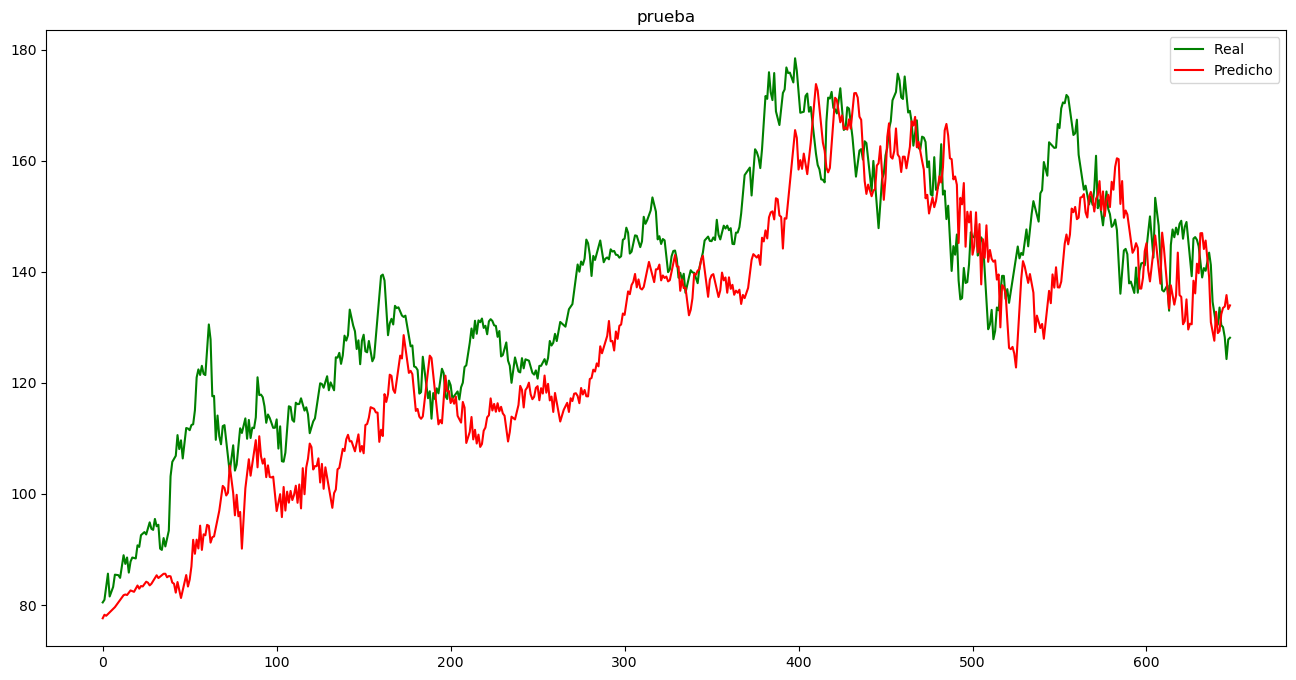

In [31]:

results=model.predict(x_val)
'''print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()
'''
# Predicciones sobre el set de validación

# --- volver a escala original usando el scaler original (scaler_raw) ---
results_real = scaler_raw.inverse_transform(results)        # (n,1)
y_val_real   = scaler_raw.inverse_transform(y_val.reshape(-1,1))

# graficar en unidades reales
plt.figure(figsize=(16, 8))
plt.plot(range(len(y_val_real)), y_val_real, color='green', label='Real ')
plt.plot(range(len(results_real)), results_real, color='red', label='Predicho')
plt.title('prueba')
plt.legend()
plt.show()

# no usado

In [32]:

# Usar el último valor de x_val como punto de partida
x_test_future = x_val[-1:]  # Último valor de x_val
future_predictions = []

# Predecir los próximos 30 días
for i in range(30):
    pred = model.predict(x_test_future)  # Hacer la predicción
    future_predictions.append(pred[0,0])  # Guardar la predicción
    # Actualizar x_test_future con el nuevo valor predicho
    x_test_future = agregarNuevoValor(x_test_future, pred[0,0])

# Transformar las predicciones futuras a su escala original
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_original = scaler_y.inverse_transform(future_predictions)

# Crear un DataFrame para las predicciones futuras
future_df = pd.DataFrame({
    'Día': range(1, 31),
    'Predicción': future_predictions_original.flatten()
})

# Mostrar las predicciones
print(future_df)

# Graficar las predicciones futuras
'''plt.figure(figsize=(10, 6))
plt.plot(future_df['Día'], future_df['Predicción'], label='Predicciones Futuras', color='red', marker='o')
plt.title('Predicción para el Próximo Mes')
plt.xlabel('Día')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid()
plt.show()'''
# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar los datos reales
plt.scatter(range(len(y_val)), y_val, c='g', label='Datos Reales', marker='o')

# Graficar las predicciones comparables
plt.scatter(range(len(results)), results, c='r', label='Predicciones Comparables', marker='x')

# Graficar las predicciones futuras
plt.plot(range(len(y_val), len(y_val) + len(future_df['Predicción'])), 
         future_df['Predicción'], label='Predicciones Futuras', color='blue', marker='o', linestyle='--')

# Configurar el título y las etiquetas
plt.title('Comparación de Datos Reales, Predicciones Comparables y Predicciones Futuras')
plt.xlabel('Índice')
plt.ylabel('Valor Predicho')

# Agregar la leyenda
plt.legend()

# Mostrar la cuadrícula
plt.grid()

# Mostrar la gráfica
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

NameError: name 'scaler_y' is not defined

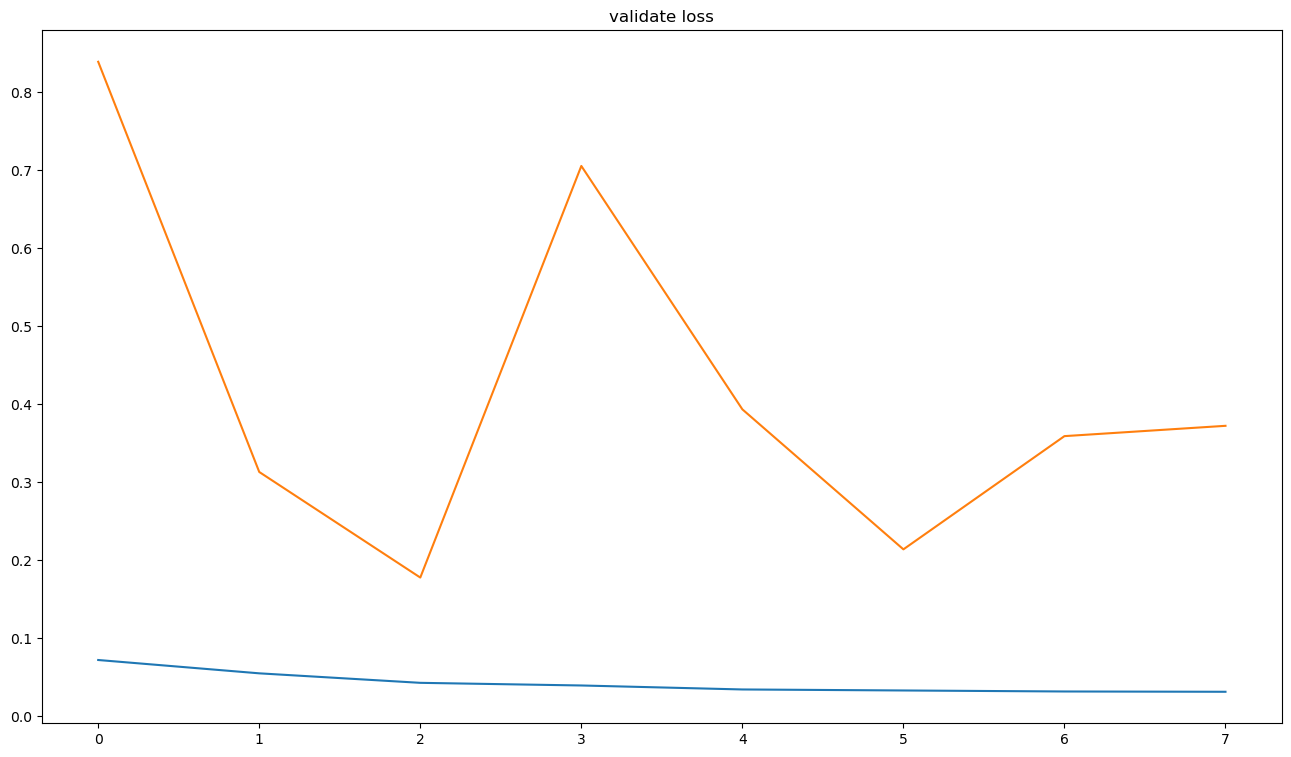

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

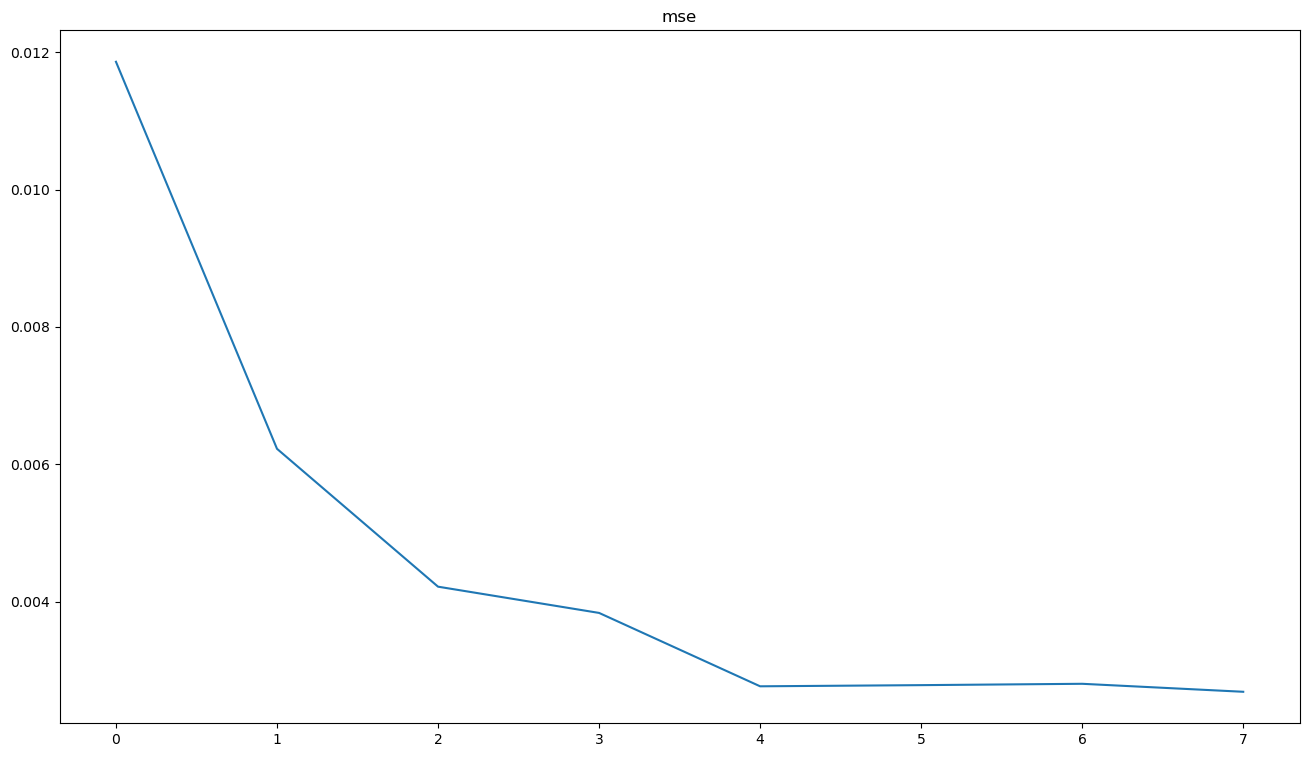

In [ ]:
plt.plot(history.history['mse'])
plt.title('mse')
plt.show()

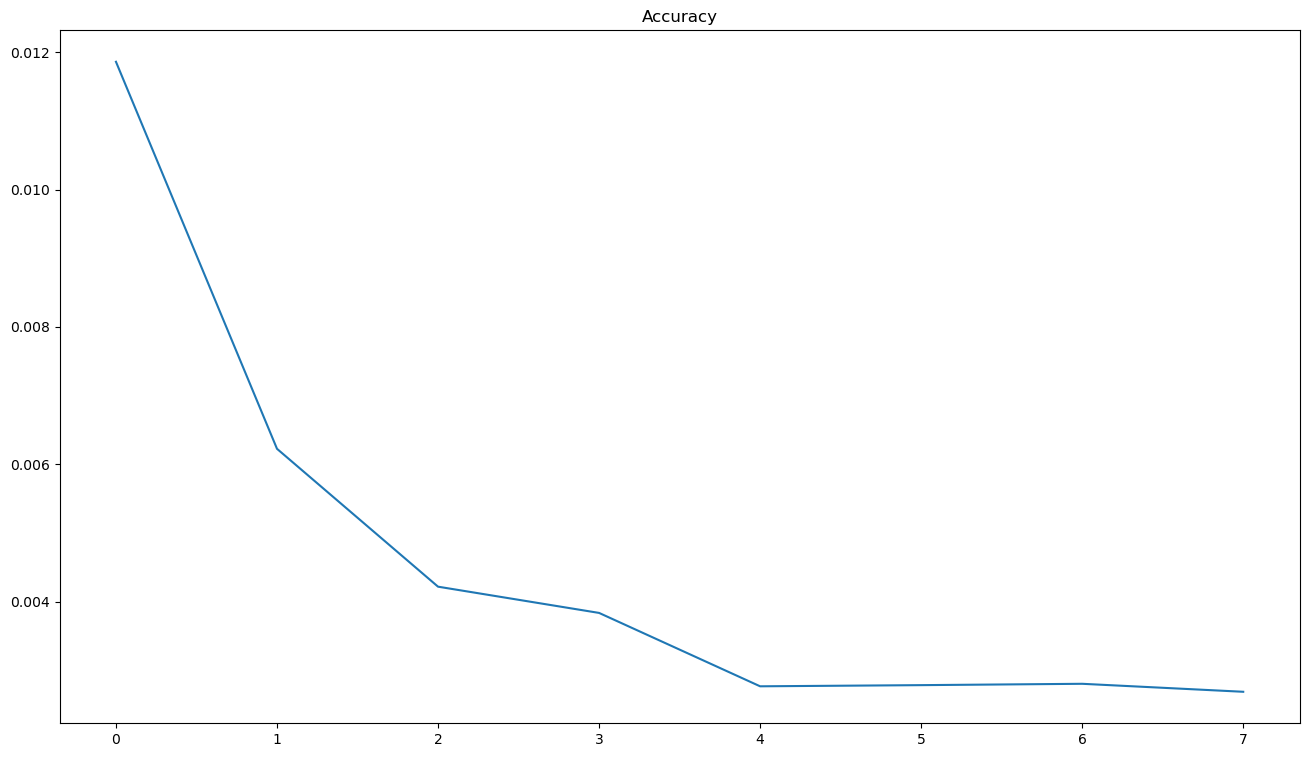

In [ ]:
plt.plot(history.history['mse'])
plt.title('Accuracy')
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,181.407394,179.046341,2.361053
1,182.528259,180.955704,1.572556
2,188.550217,182.417999,6.132217
3,193.611359,184.419922,9.191437
4,183.923660,186.798370,-2.874710


In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,181.407394,179.046341,2.361053
1,182.528259,180.955704,1.572556
2,188.550217,182.417999,6.132217
3,193.611359,184.419922,9.191437
4,183.923660,186.798370,-2.874710


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,649.000000,649.000000,649.000000
mean,314.064484,328.492554,-14.428089
std,50.442429,55.024223,11.546115
min,181.407394,179.046341,-51.828125
25%,280.250275,291.980072,-21.627838
50%,319.927307,339.807800,-14.122986
75%,347.174500,365.519836,-6.185455
max,412.227936,425.773102,20.014633


In [ ]:
# Calcular métricas de rendimiento
mse = mean_squared_error(compara2['real'], compara2['prediccion'])
rmse = mse ** 0.5
mae = mean_absolute_error(compara2['real'], compara2['prediccion'])
r2 = r2_score(compara2['real'], compara2['prediccion'])

# Mostrar resultados
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

Root Mean Squared Error (RMSE): 18.47368915950762
Mean Absolute Error (MAE): 15.332124710083008
R^2 Score: 0.8656663034831419


<Axes: >

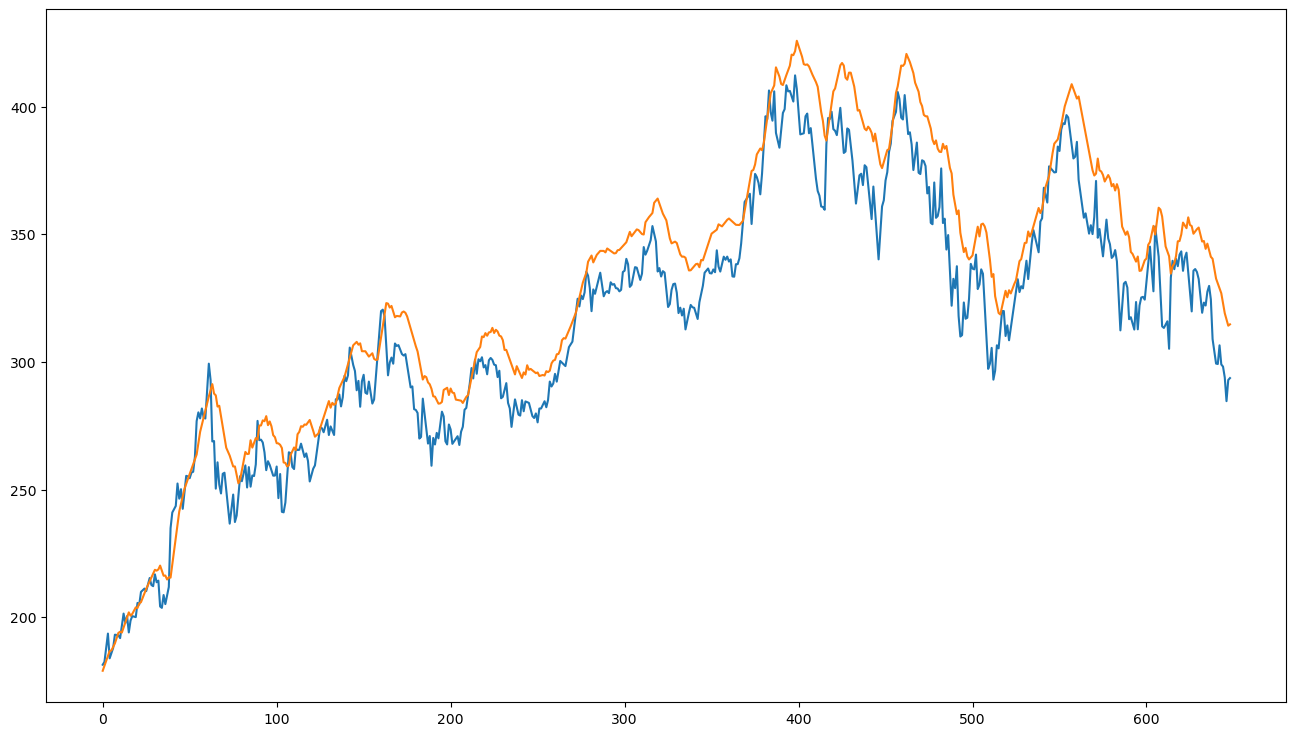

In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()

## Predicción

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [ ]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

Date
2018-11-16    46.048183
2018-11-19    44.223206
2018-11-20    42.110313
2018-11-21    42.062717
2018-11-23    40.994381
2018-11-26    41.548771
2018-11-27    41.458359
2018-11-28    43.052540
2018-11-29    42.721809
2018-11-30    42.491009
Name: Close, dtype: float64

### Preparamos los datos para Test

In [ ]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
print("Número de columnas en reframed:", reframed.shape[1])
#reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head()

Número de columnas en reframed: 2


,var1(t-1),var1(t)
1,1.000000,0.277781
2,0.277781,-0.558380
3,-0.558380,-0.577215
4,-0.577215,-1.000000
5,-1.000000,-0.780605


In [ ]:
values = reframed.values
x_test = values[2:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(7, 1, 2)


array([[[-0.5583801 , -0.5772152 ]],

       [[-0.5772152 , -1.        ]],

       [[-1.        , -0.7806053 ]],

       [[-0.7806053 , -0.81638527]],

       [[-0.81638527, -0.1855011 ]],

       [[-0.1855011 , -0.31638527]],

       [[-0.31638527, -0.40772247]]], dtype=float32)

### Pronóstico para la "próxima semana"

In [ ]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

'''results = []
for i in range(7):
    parcial = model.predict(x_test)
    print("Parcial:", parcial)
    
    # Validate the output of model.predict
    if not np.isfinite(parcial).all():
        raise ValueError(f"Invalid value in model prediction: {parcial}")
    
    results.append(parcial[0])
    print("x_test before agregarNuevoValor:", x_test)
    
    # Validate x_test before updating
    if not np.isfinite(x_test).all():
        raise ValueError(f"Invalid value in x_test: {x_test}")
    
    x_test = agregarNuevoValor(x_test, parcial[0])'''
    

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/flatten_1/Reshape defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\alfmi\anaconda3\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\alfmi\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\alfmi\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\alfmi\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\alfmi\AppData\Local\Temp\ipykernel_32980\531443222.py", line 3, in <module>

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 504, in predict

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 204, in one_step_on_data_distributed

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 194, in one_step_on_data

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 92, in predict_step

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4415, in reshape

  File "c:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1778, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/flatten_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_114808]

### Re-Convertimos los resultados

In [ ]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Visualizamos el pronóstico

<Axes: >

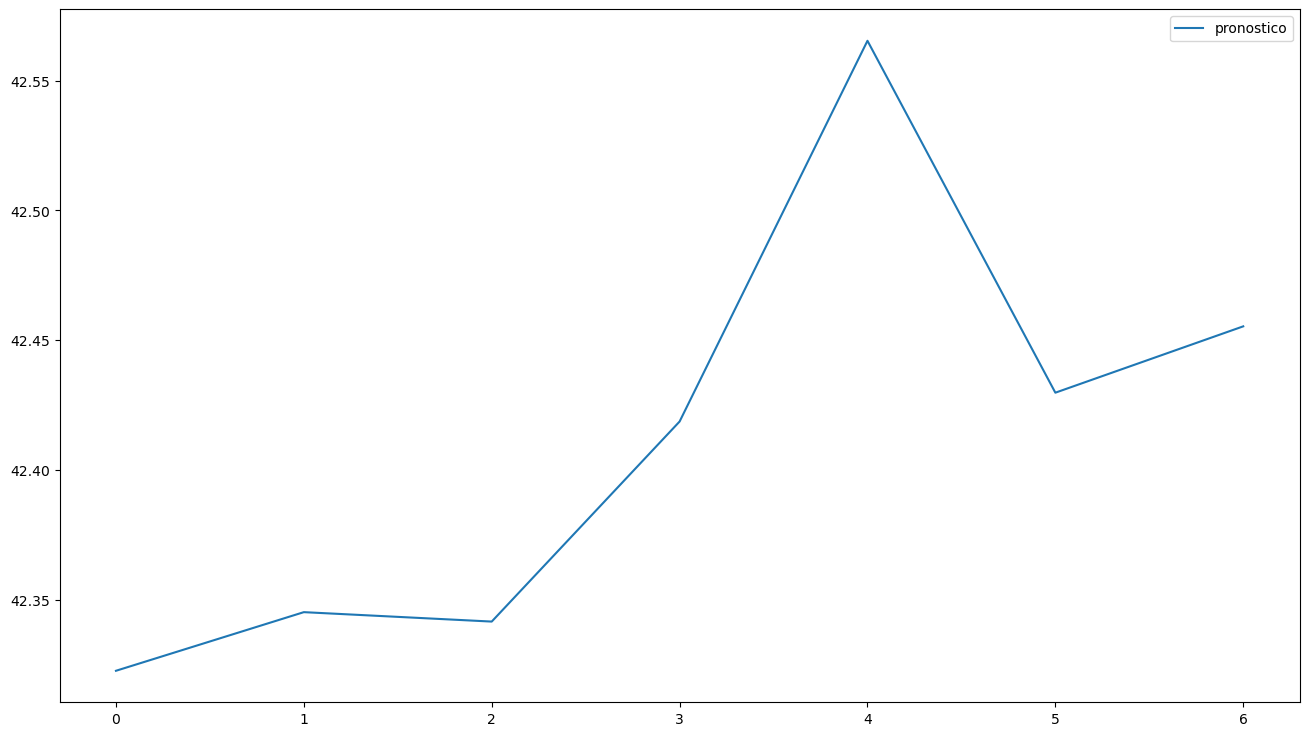

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
#prediccion1SemanaDiciembre.to_csv('pronostico.csv')



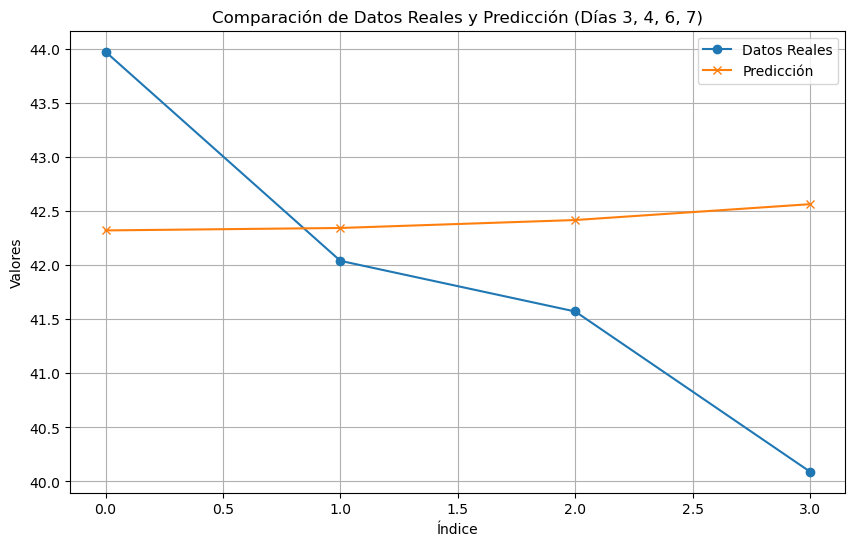

In [ ]:
# Seleccionar los datos reales para las fechas específicas
datos_reales = df.loc[['2018-12-03', '2018-12-04', '2018-12-06', '2018-12-07']]



# Ajustar los índices de las predicciones para que coincidan con los índices de los datos reales
prediccion1SemanaDiciembre = prediccion1SemanaDiciembre.iloc[[0, 1, 3, 4]].reset_index(drop=True)

# Graficar los datos reales y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(range(len(datos_reales)), datos_reales.values, label='Datos Reales', marker='o')
plt.plot(range(len(prediccion1SemanaDiciembre)), prediccion1SemanaDiciembre.values, label='Predicción', marker='x')
plt.title('Comparación de Datos Reales y Predicción (Días 3, 4, 6, 7)')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.legend()
plt.grid()
plt.show()

In [ ]:
prediccion1SemanaDiciembre

,pronostico
0,42.322608
1,42.345196
2,42.418641
3,42.565341
